IMPORT LIBRARIES

In [1]:
import numpy as np
import copy
import random
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import GraphData as sgl
from subroutines_imagenes_microscopio import *

LOAD DATA, PREPARE SHAPE AND NORMALIZED

In [2]:
# Read the data 
f = open("data_imagenes_recortadas.bin","rb")
np_subimages = np.load(f)
np_sublabels = np.load(f)
np_index = np.load(f)
f.close()

# Choose only the first image (4096 subimages)
subimages = np.zeros((4096, 64, 64))
sublabels = np.zeros((4096,))
index = np.zeros((4096,))
for i in range (4096):
    subimages[i] = np_subimages[i]
    sublabels[i] = np_sublabels[i]
    index[i] = np_index[i]

# Dimension of the data 
number_of_images, width, height = subimages.shape

# Setting maximum value of the pixel = 1 
maximum = subimages.max()
subimages = subimages / maximum

mean = subimages.mean() 
std = subimages.flatten().std()

strech_factor = 5
subimages = strech_factor * (subimages - mean + strech_factor * std)

PARAMETERS FOR THE CALCULATION

In [3]:
# Paremeter for decide if we want to run or load the network
run_NeuralNetwork = False

# Parameters that control the calculation

epochs = 300
minib_size = 10

nneurons = 100
n_narrow = 15

train_ratio = 0.89
val_ratio = 0.1
test_ratio = 0.01

SPLIT TRAINING, VALIDATION AND TEST DATA

In [4]:
# Creating the training, validation and test sets 
#x_train, x_val, x_test = split_data(train_ratio, val_ratio, test_ratio, subimages)
x_train, x_val, x_test, y_val, y_train, y_test = split_train_val_test(subimages, index, train_ratio, val_ratio, test_ratio)
print(x_train.shape[1])  
print(y_train.shape)
ntrain, nval, ntest = x_train.shape[0], x_val.shape[0], x_test.shape[0]
print(ntrain, nval, ntest)

# Flattening each set to a vector
x_train = x_train.reshape((ntrain, width*height))
x_val = x_val.reshape((nval, width*height))
x_test = x_test.reshape((ntest, width*height))

64
(3645,)
3645 410 41


AUTOENCODER

In [5]:
# creating the autoencoder
npoints_in = npoints_out = x_train.shape[1]

# Build the model

model = tf.keras.models.Sequential([\
        tf.keras.layers.Input(shape=(npoints_in,)),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(nneurons,activation=tf.keras.layers.LeakyReLU(),\
                              kernel_initializer='random_normal',\
                              bias_initializer='random_normal'), 
        tf.keras.layers.Dense(nneurons/2, activation=tf.keras.layers.LeakyReLU(),\
                              kernel_initializer='random_normal',\
                              bias_initializer='random_normal'),
        tf.keras.layers.Dense(n_narrow, activation=tf.keras.layers.LeakyReLU(),\
                              kernel_initializer='random_normal',\
                              bias_initializer='random_normal'),
        tf.keras.layers.Dense(nneurons/2, activation=tf.keras.layers.LeakyReLU(),\
                              kernel_initializer='random_normal',\
                              bias_initializer='random_normal'),
        tf.keras.layers.Dense(nneurons, activation=tf.keras.layers.LeakyReLU(),\
                              kernel_initializer='random_normal',\
                              bias_initializer='random_normal'),
        tf.keras.layers.Dense(npoints_out, activation='sigmoid',\
                              kernel_initializer='random_normal',\
                              bias_initializer='random_normal')
                                ])
model.summary()

loss_function = 'mse'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001, epsilon= 1e-8)

model.compile(optimizer=opt, loss=loss_function, metrics=[tf.keras.metrics.RootMeanSquaredError()])

if (run_NeuralNetwork):
    # Fitting the model
    history = model.fit(x_train, x_train,
                  batch_size = minib_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, x_val))
    
    #saving the model
    model.save('model5')
else:
    # Load the model
    model = tf.keras.models.load_model('model5')
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 100)               409700    
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 15)                765       
                                                                 
 dense_3 (Dense)             (None, 50)                800       
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dense_5 (Dense)             (None, 4096)              4

PLOTTING THE RESULTS: MODEL SUMMARY, SCORE AND PERFORMANCE

Training loss:  0.007227164693176746
Training rmse:  0.08501273393630981
Val loss:  0.007259551435709
Val rmse:  0.08520299941301346
Test loss:  0.0071516502648591995
Test rmse:  0.08456743508577347
2/2 [==============================] - 0s 5ms/step
(4096, 64, 64)


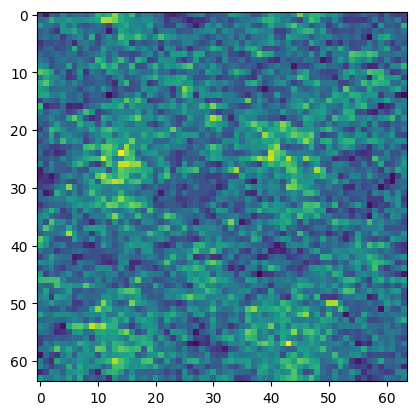

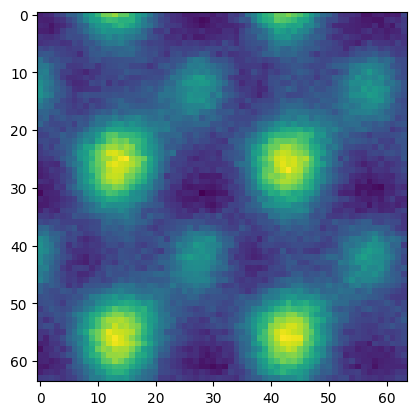

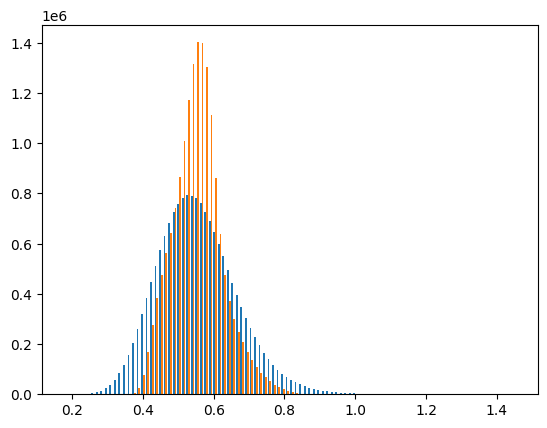

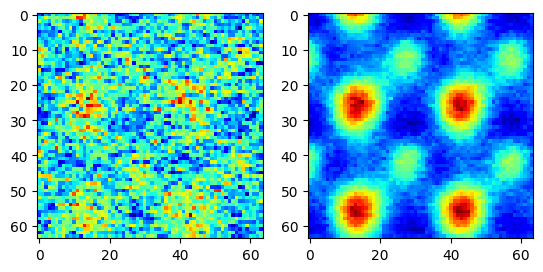

In [6]:
# Evaluating how good the model is
score_train = model.evaluate(x_train, x_train, verbose=0)
score_val = model.evaluate(x_val, x_val, verbose=0)
score_test = model.evaluate(x_test, x_test, verbose=0)
print('Training loss: ', score_train[0])
print('Training rmse: ', score_train[1])
print('Val loss: ', score_val[0])
print('Val rmse: ', score_val[1])
print('Test loss: ', score_test[0])
print('Test rmse: ', score_test[1])

# Predictions
x_predict_train= model.predict(x_train)
x_predict_val= model.predict(x_val)
x_predict_test= model.predict(x_test)

images_train = x_train.reshape((ntrain, width, height))
images_val = x_val.reshape((nval, width, height))
images_test = x_test.reshape((ntest, width, height))

images_predict_train = x_predict_train.reshape((ntrain, width, height))
images_predict_val = x_predict_val.reshape((nval, width, height))
images_predict_test = x_predict_test.reshape((ntest, width, height))

#Reordeno los recortes con sus respectivos índices y los guardo en un fichero
images_predict = np.concatenate((images_predict_train, images_predict_val, images_predict_test))
image_original = np.concatenate((images_train, images_val, images_test))
y = np.concatenate((y_train, y_val, y_test))

ref = np.zeros((images_predict.shape[0], images_predict.shape[1], images_predict.shape[2]))
print(ref.shape)
for i in range (len(y)):
    min = i
    for j in range (len(y)):
        if int(y[j]) == min:

            minim = y[j]
            ref[j] = images_predict[j]

            y[j] = y[i]
            images_predict[j] = images_predict[i]

            y[i] = minim
            images_predict[i] = ref[j]

filtered_images = images_predict[:,:,:]
labels_ordened = y[:]

f = open("data_filtered_reordened_images_model5.bin", "wb")
np.save(f, filtered_images)
np.save(f, labels_ordened)
f.close()

##Guardo la history en un array
#evolution_loss = np.zeros((len(history.history['loss'])))
#evolution_rmse = np.zeros((len(history.history['root_mean_squared_error'])))
#evolution_val_loss = np.zeros((len(history.history['val_loss'])))
#evolution_val_rmse = np.zeros((len(history.history['val_root_mean_squared_error'])))
#
#evolution_loss = history.history['loss']
#evolution_rmse = history.history['root_mean_squared_error']
#evolution_val_loss = history.history['val_loss']
#evolution_val_rmse = history.history['val_root_mean_squared_error']
#
##Escribe los datos del entrenamiento en un fichero
#f = open("loss_evolution_model5.bin", "wb")
#np.save(f, evolution_loss)
#np.save(f, evolution_rmse)
#np.save(f, evolution_val_loss)
#np.save(f, evolution_val_rmse)
#f.close()
#
## Plot images and figures
#plot_score("C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Dense/Data_Loss" , history)
#
#n_epochs = np.arange(len(history.history['loss']))
#sgl.GraphData([[n_epochs, history.history['loss']],
#            [n_epochs,  history.history['val_loss']]],['r', 'b'], 
#            ['Train', 'Validation'],'','C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Dense/Loss_model5.png', Axx='$Epochs$', Axy='$Loss$')

# Showing some results
ind = 0
plt.imshow(subimages[ind])
plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Dense/Original_test_model5.png', bbox_inches='tight')
plt.show()
plt.imshow(images_predict[ind])
plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Dense/Reduced_test_model5.png',dpi=200, bbox_inches='tight',  facecolor="#f1f1f1" )
plt.show()
plt.hist([subimages.flatten(), images_predict.flatten()], bins=100)
plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Dense/Histogram_test_model5.png',dpi=200, bbox_inches='tight',  facecolor="#f1f1f1" )
plt.show()
plot_one_image_and_prediction(subimages[ind], images_predict[ind])
plt.savefig('C:/Users/PORTATIL/Desktop/TFG/Figuras Definitivas/Autoencoder Dense/Comparison_test_model5.png',dpi=200, bbox_inches='tight',  facecolor="#f1f1f1" )
plt.show()